# Configuración e importación de librerías



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import tifffile as tiff

import cv2
from google.colab.patches import cv2_imshow

from imutils import contours
from skimage import measure
import imutils

In [3]:
!pip install --upgrade pip setuptools

     |████████████████████████████████| 1.5MB 14.0MB/s 
     |████████████████████████████████| 2.0MB 74.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
  Found existing installation: setuptools 51.0.0
    Uninstalling setuptools-51.0.0:
      Successfully uninstalled setuptools-51.0.0


In [4]:
!pip install --upgrade imagecodecs
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 17.9 MB 113 kB/s 
     |████████████████████████████████| 56.3 MB 39 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


# Conjunto de datos


**Ortofoto Este Combinada**

Recorte óptico

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f3d9e782ef0>)

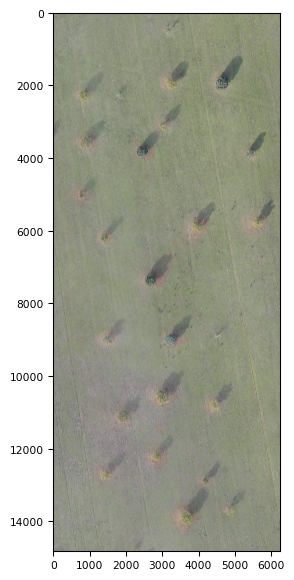

In [ ]:
east_orthophoto_rgb = tiff.imread('/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/T-este_def-2-3.tif')
tiff.imshow(east_orthophoto_rgb)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f3d9da68160>)

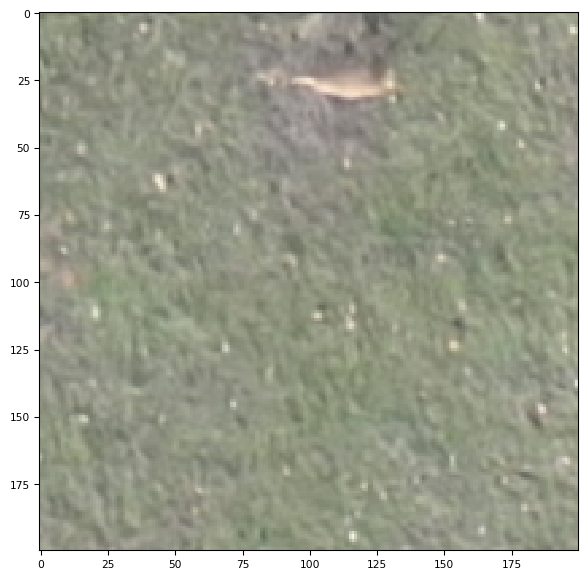

In [ ]:
tiff.imshow(east_orthophoto_rgb[6000:6200,3000:3200])

In [ ]:
east_orthophoto_rgb.shape

(14816, 6236, 3)


Recorte térmico

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f2930034f60>)

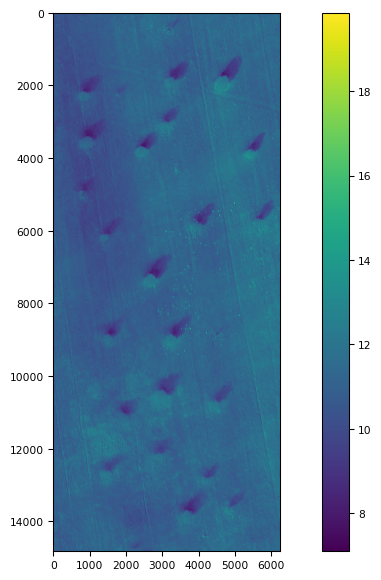

In [ ]:
east_orthophoto_thm = tiff.imread('/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/THM_def/T-Este_THM-2-3.tif')
tiff.imshow(east_orthophoto_thm)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f292ff7f438>)

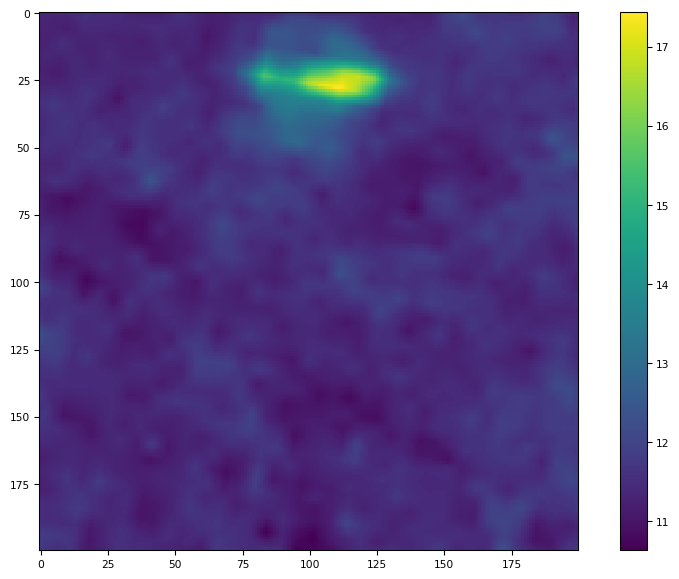

In [ ]:
tiff.imshow(east_orthophoto_thm[6000:6200,3000:3200])

In [ ]:
east_orthophoto_thm.shape

(14816, 6236)

**Ortofotos Este RGB, THM**

En los ficheros RGB, THM individuales el solape y las dimensiones no coinciden

Recorte RGB

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f2930f45198>)

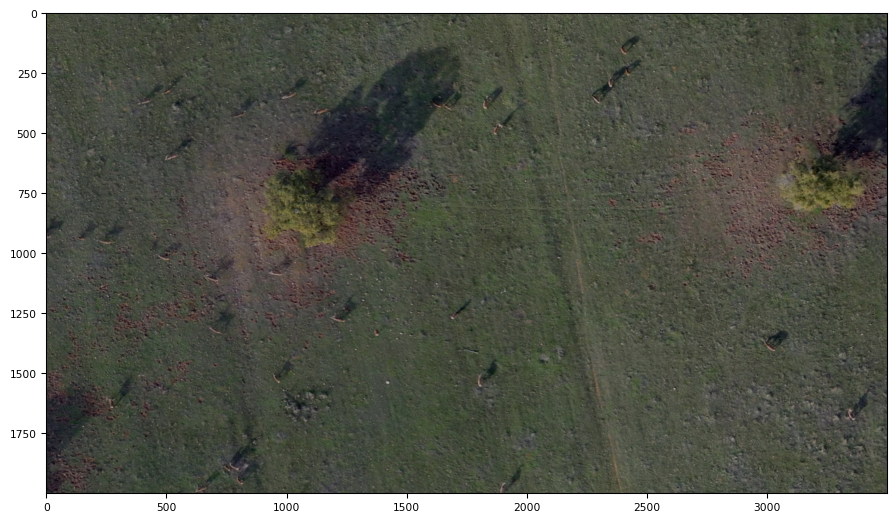

In [ ]:
# Optical image
image_optical= tiff.imread('/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/T-Este_RGB-1-2.tif')
tiff.imshow(image_optical[12500:14500,0:3500])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f2930f26898>)

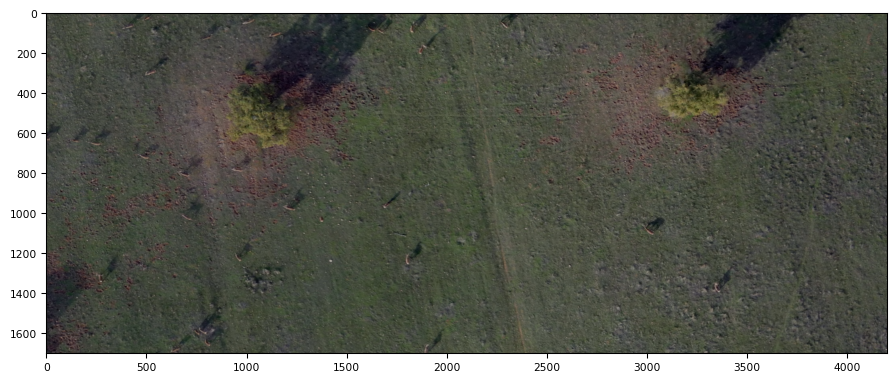

In [ ]:
# Optical image shifted
image_optical_shifted= tiff.imread('/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/T-Este_RGB-1-2.tif')
tiff.imshow(image_optical_shifted[12800:14500,0:4200])

In [ ]:
image_optical.shape

(18520, 20069, 3)

Recorte THM

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f2930e9d160>)

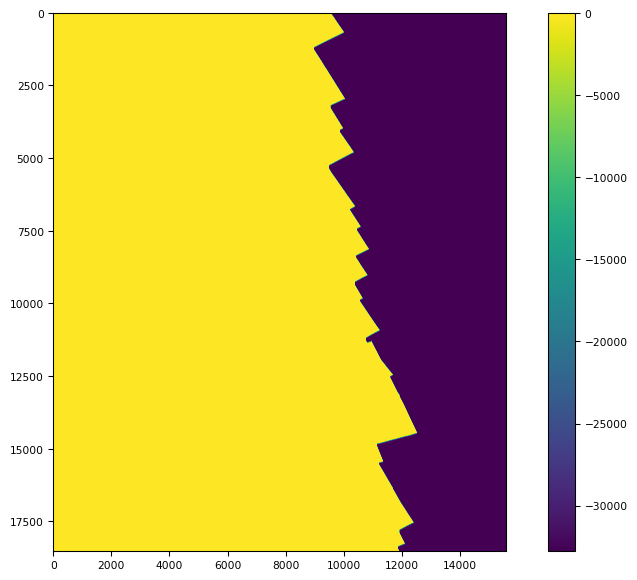

In [ ]:
east_orthophoto_thm = tiff.imread('/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/T-Este_THM-1-2.tif')
tiff.imshow(east_orthophoto_thm)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f2930f588d0>)

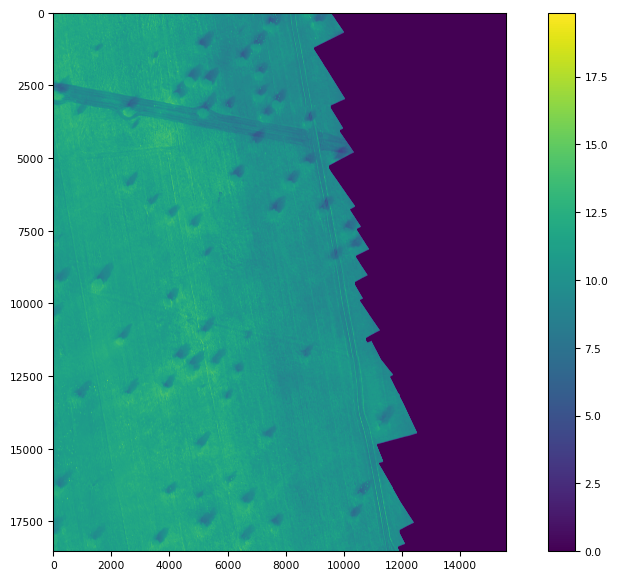

In [ ]:
east_orthophoto_thm_trunc = np.where(east_orthophoto_thm < 0, 0, east_orthophoto_thm)
tiff.imshow(east_orthophoto_thm_trunc)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f2930cfb3c8>)

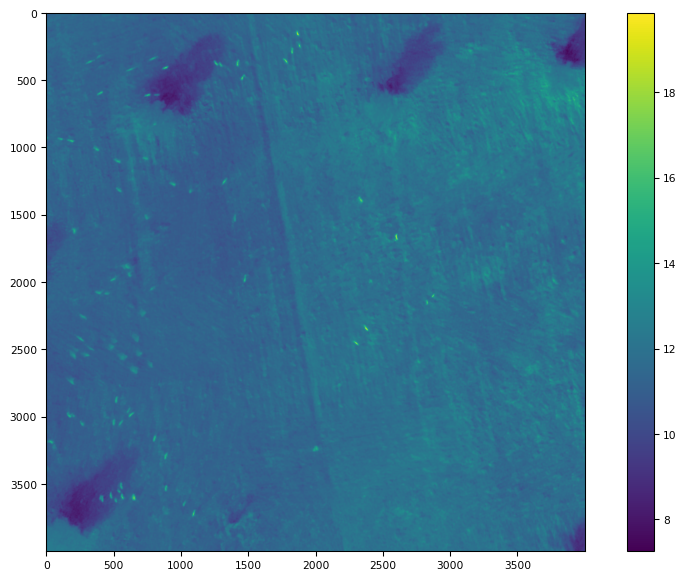

In [ ]:
tiff.imshow(east_orthophoto_thm_trunc[12500:16500,0:4000])

In [ ]:
east_orthophoto_thm.shape

(18520, 15590)

## Localización de ciervos

**Nota**: Trabajaremos sobre los recortes de los **vuelos definitivos**, ya que las imágenes completas son demasiado pesadas.

#### Parte 1: obtener localización de los ciervos en las imágenes térmicas

Obtenemos la localización de los ciervos utilizando findCountours() y boundingRect()

Ver
https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html
https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html

findContours() acepta imágenes en escala de grises (único canal) con formato de 8 bits. Nuestra imagen original es de tipo 32 float, por lo que debemos convertirla a 8 bit.

"Source, an 8-bit single-channel image. If mode equals to CV_RETR_CCOMP or CV_RETR_FLOODFILL, the input can also be a 32-bit integer image of labels (CV_32SC1)."

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb6600780>)

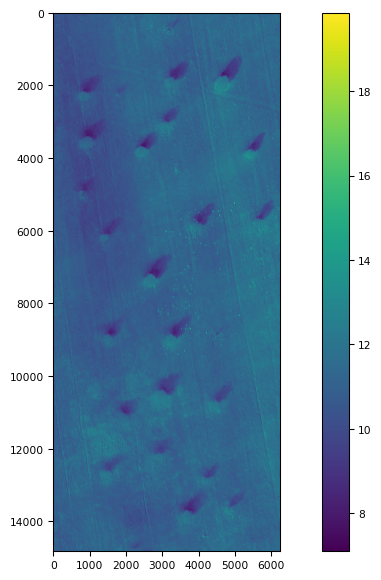

In [68]:
# load and preprocess the thermal image
east_orthophoto_thm = cv2.imread('/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/THM_def/T-Este_THM-2-3.tif', cv2.IMREAD_UNCHANGED)

tiff.imshow(east_orthophoto_thm)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb652e748>)

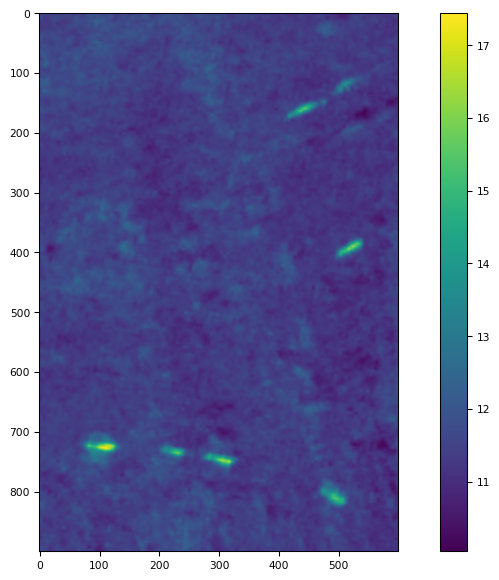

In [69]:
image_thermal= east_orthophoto_thm[5300:6200,3000:3600]
tiff.imshow(image_thermal)

Para disminuir el efecto del ruido en la detección de contornos, suavizamos la imagen aplicando un filtro.
Existen varias técnicas, en este caso utilizamos un filtro Gaussiano.

Consultar para ver la lista de filtros disponibles https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html

In [70]:
# convert to 8-bit format
image_thermal_scale= cv2.convertScaleAbs(image_thermal)

# Apply a Gaussian blur
radius= 11
image_thermal_scale = cv2.GaussianBlur(src=image_thermal_scale, ksize=(radius, radius), sigmaX=0, sigmaY=0)

# threshold the thermal image to reveal light regions
thresh= 12
ret, thresh = cv2.threshold(src= image_thermal_scale, thresh= thresh, maxval= 255, type= cv2.THRESH_BINARY)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb64de978>)

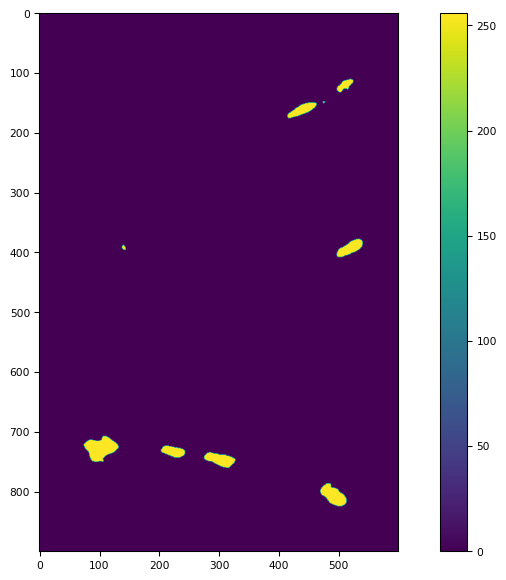

In [71]:
tiff.imshow(thresh)

In [72]:
# find contours
contours, hierarchy= cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)

n_cnt= len(contours)
print("Number of countours found: %d" %n_cnt)

Number of countours found: 9


(x,y) rectangle top-left coordinates 470 787
(w,h) rectangle width and height 44 38


(x,y) rectangle top-left coordinates 276 735
(w,h) rectangle width and height 52 26


(x,y) rectangle top-left coordinates 204 724
(w,h) rectangle width and height 40 20


(x,y) rectangle top-left coordinates 75 708
(w,h) rectangle width and height 58 43


(x,y) rectangle top-left coordinates 138 389
(w,h) rectangle width and height 7 8


(x,y) rectangle top-left coordinates 497 379
(w,h) rectangle width and height 44 30


(x,y) rectangle top-left coordinates 415 151
(w,h) rectangle width and height 49 26


(x,y) rectangle top-left coordinates 498 112
(w,h) rectangle width and height 27 22




(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb6419518>)

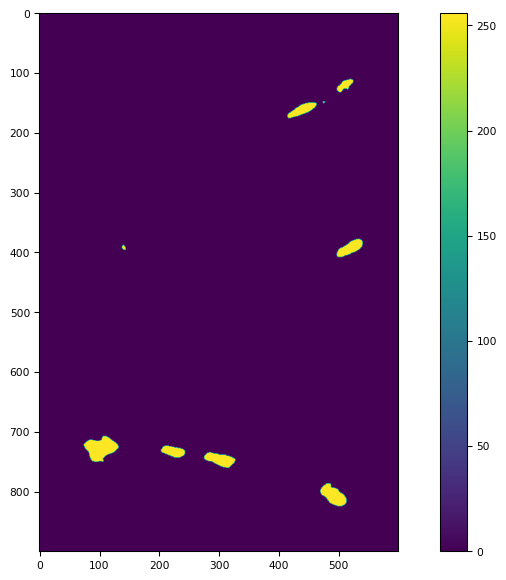

In [73]:
w_limit=6
h_limit=6

for c in contours:
  x, y, w, h = cv2.boundingRect(c)
  if w>w_limit and h>h_limit:
    print("(x,y) rectangle top-left coordinates %d %d" %(x, y))
    print("(w,h) rectangle width and height %d %d" %(w, h))
    print("\n")
    #cv2.rectangle(img=thresh, pt1=(x,y), pt2=(x+w,y+h), color=(155,155,0), thickness=1)

tiff.imshow(thresh)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb8189c88>)

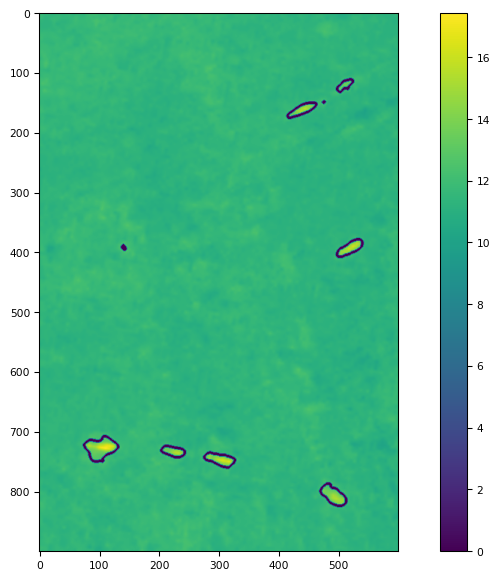

In [74]:
# draw all contours on the original image to visually analyse the result
cv2.drawContours(image_thermal, contours, -1, (0,120,0), 3)

tiff.imshow(image_thermal)

In [ ]:
# draw 1st contour to visually analyse the result
#cnt = contours[0]
#cv2.drawContours(image_thermal, [cnt], 0, (0,255,0), 3)

#tiff.imshow(image_thermal)

#### Parte 2: 

Una vez localizados los ciervos en las imágenes térmicas, utilizamos las coordenadas de los bounding box (x,y,w,h) para localizarlos en las imágenes ópticas.

**Nota**: se debe estudiar el solape entre las imágenes térmicas y ópticas. Si hubiera un desplazamiento, se puede sumar una constante k a los valores hallados de w y h.

Una vez hallados los contornos y las coordenadas de cada bounding rectangle, podemos aplicar uno de los métodos siguientes:

*   Método 1: recortar la región de interés (ROI)
*   Método 2: crear una máscara que oculte la información irrelevante y solamente mantenga la región de interés (ROI)


Como pueden existir múltiples contornos en cada imagen, creamos una imagen por contorno localizado. Este procedimiento permite que la red neuronal se limite a clasificar cada imagen con una única etiqueta, simplificando enormemente el problema inicial de localización y clasificación de múltiples objetos por imagen

Antes de explorar estos métodos, comparemos el recorte de las imágenes óptica y térmica para analizar el solape

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb790c828>)

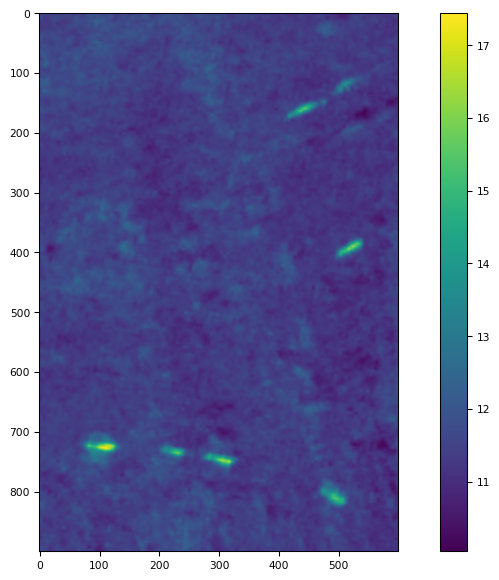

In [75]:
# Thermal image
east_orthophoto_thm = cv2.imread('/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/THM_def/T-Este_THM-2-3.tif', cv2.IMREAD_UNCHANGED)
image_thermal= east_orthophoto_thm[5300:6200,3000:3600]

tiff.imshow(image_thermal)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb6210860>)

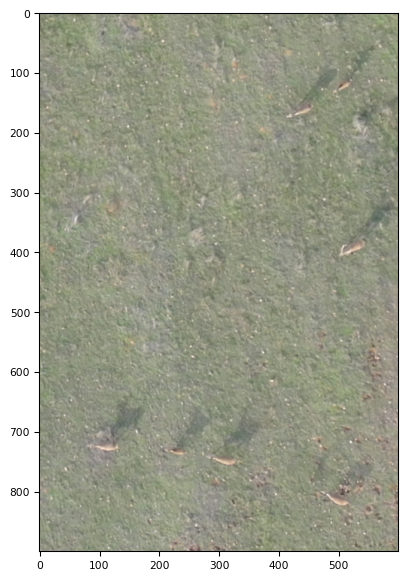

In [76]:
# Optical image
east_orthophoto_rgb = tiff.imread('/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/T-este_def-2-3.tif')
image_optical= east_orthophoto_rgb[5300:6200,3000:3600]

tiff.imshow(image_optical)

##### Método 1: recortar (crop) la región de interés (ROI) y escribir a fichero

Nota: tanto en Numpy como en OpenCV el sistema de coordenadas es columnas (eje x), filas (eje y) con origen en la esquina superior izquierda.
Sin embargo, en OpenCV se accede a una imagen utilizando Img[col, row] y en Numpy se accede utilizando Image[row, col], de ahí que cuando definimos ROI utilicemos ROI = new_image[y:y+h, x:x+w]

Ver https://lionbridge.ai/articles/learning-the-opencv-and-numpy-image-coordinate-systems/


In [166]:
# load and preprocess the thermal image
east_orthophoto_thm = cv2.imread('/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/THM_def/T-Este_THM-2-3.tif', cv2.IMREAD_UNCHANGED)
image_thermal= east_orthophoto_thm[5300:6200,3000:3600]

# convert to 8-bit format
image_thermal_scale= cv2.convertScaleAbs(image_thermal)

# Apply a Gaussian blur
radius= 11
image_thermal_scale = cv2.GaussianBlur(src=image_thermal_scale, ksize=(radius, radius), sigmaX=0, sigmaY=0)

# load the optical image
east_orthophoto_rgb = tiff.imread('/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/T-este_def-2-3.tif')
image_optical= east_orthophoto_rgb[5300:6200,3000:3600]

# threshold the thermal image to reveal light regions
thresh=12
ret, thresh = cv2.threshold(src= image_thermal_scale, thresh= thresh, maxval= 255, type= cv2.THRESH_BINARY)
# find contours
contours, hierarchy= cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
n_cnt= len(contours)
print("Number of countours found before filtering: %d" %n_cnt)
print("\n")

# Find bounding box, extract ROI, write cropped optical image to file
w_limit=6 #boundingRect width limit
h_limit=6 #boundingRect height limit
k= 20     #boundingRect padding on masked image
for i, c in enumerate(contours):
  x, y, w, h = cv2.boundingRect(c)
  if w>w_limit and h>h_limit:
    print(i)
    print("(x,y) rectangle top-left coordinates %d %d" %(x, y))
    print("(w,h) rectangle width and height %d %d" %(w, h))
    print("\n")

    ROI = image_optical[y-k:y+h+k, x-k:x+w+k]
    cv2.imwrite('/content/drive/My Drive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/Thermal_Cropped_ROI/east_orthophoto_rgb_ROI_%d.tif' %i, ROI)

Number of countours found before filtering: 9


0
(x,y) rectangle top-left coordinates 470 787
(w,h) rectangle width and height 44 38


1
(x,y) rectangle top-left coordinates 276 735
(w,h) rectangle width and height 52 26


2
(x,y) rectangle top-left coordinates 204 724
(w,h) rectangle width and height 40 20


3
(x,y) rectangle top-left coordinates 75 708
(w,h) rectangle width and height 58 43


4
(x,y) rectangle top-left coordinates 138 389
(w,h) rectangle width and height 7 8


5
(x,y) rectangle top-left coordinates 497 379
(w,h) rectangle width and height 44 30


6
(x,y) rectangle top-left coordinates 415 151
(w,h) rectangle width and height 49 26


8
(x,y) rectangle top-left coordinates 498 112
(w,h) rectangle width and height 27 22




Examinemos el resultado. Comprobamos que el método funciona correctamente.

In [167]:
image_optical_ROI_0 = cv2.imread('/content/drive/My Drive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/Thermal_Cropped_ROI/east_orthophoto_rgb_ROI_0.tif', cv2.IMREAD_UNCHANGED)
image_optical_ROI_1 = cv2.imread('/content/drive/My Drive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/Thermal_Cropped_ROI/east_orthophoto_rgb_ROI_1.tif', cv2.IMREAD_UNCHANGED)

In [168]:
print(image_optical.shape)
print(image_optical_ROI_0.shape)
print(image_optical_ROI_1.shape)

(900, 600, 3)
(78, 84, 3)
(66, 92, 3)


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb52f3a58>)

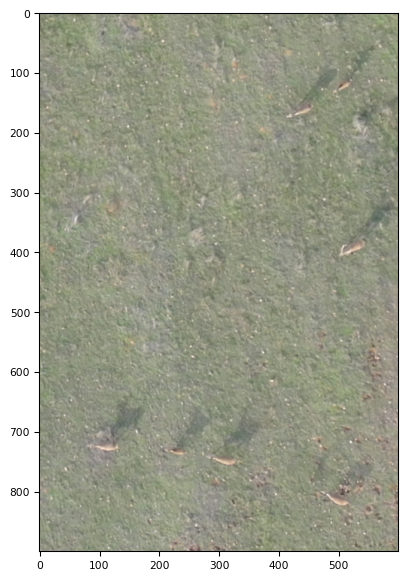

In [169]:
tiff.imshow(image_optical)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb52d94e0>)

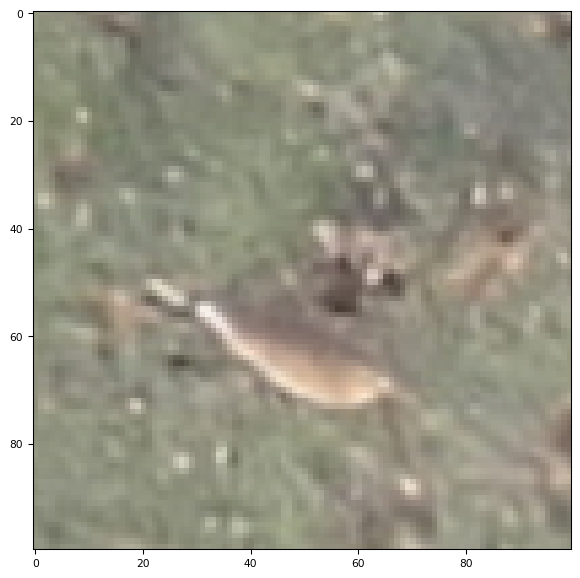

In [170]:
tiff.imshow(image_optical[750:850, 450:550])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb5230278>)

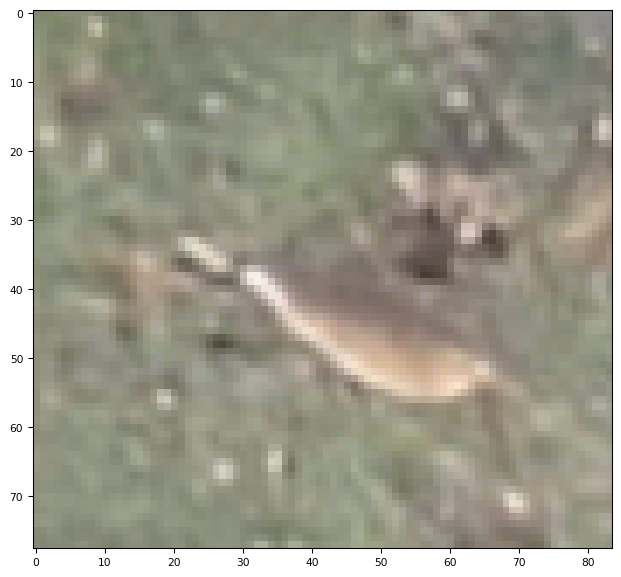

In [171]:
tiff.imshow(image_optical_ROI_0)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb5214a20>)

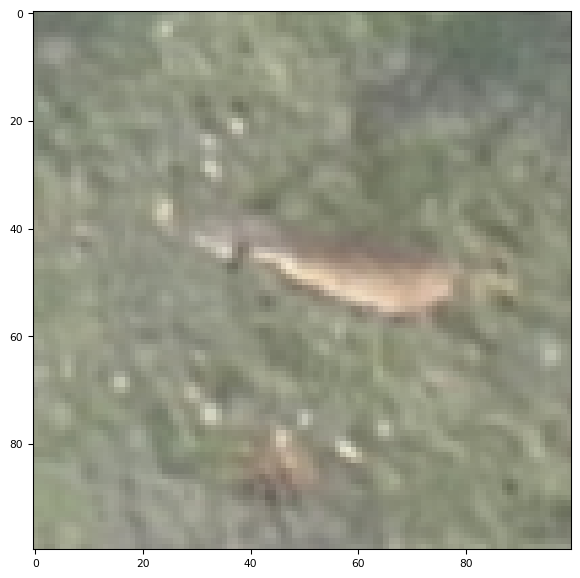

In [172]:
tiff.imshow(image_optical[700:800, 250:350])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb516a978>)

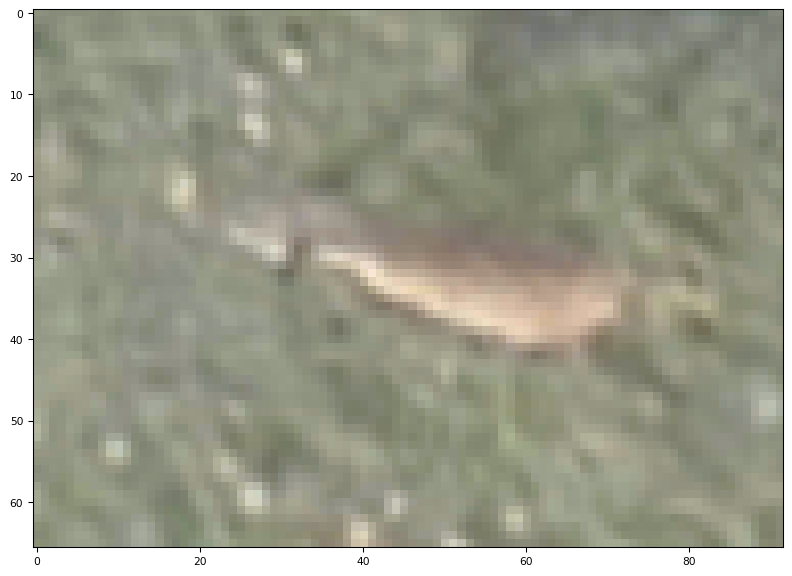

In [173]:
tiff.imshow(image_optical_ROI_1)

##### Método 2: crear una máscara oculte toda la imagen excepto la región de interés (ROI) y escribir a fichero

In [156]:
# load and preprocess the thermal image
east_orthophoto_thm = cv2.imread('/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/THM_def/T-Este_THM-2-3.tif', cv2.IMREAD_UNCHANGED)
image_thermal= east_orthophoto_thm[5300:6200,3000:3600]

# convert to 8-bit format
image_thermal_scale= cv2.convertScaleAbs(image_thermal)

# Apply a Gaussian blur
radius= 11
image_thermal_scale = cv2.GaussianBlur(src=image_thermal_scale, ksize=(radius, radius), sigmaX=0, sigmaY=0)

# load the optical image
east_orthophoto_rgb = tiff.imread('/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/ortofotos_recortadas/T-este_def-2-3.tif')
image_optical= east_orthophoto_rgb[5300:6200,3000:3600]

# threshold the thermal image to reveal light regions
thresh= 12
ret, thresh = cv2.threshold(src= image_thermal_scale, thresh= thresh, maxval= 255, type= cv2.THRESH_BINARY)
# find contours
contours, hierarchy= cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
n_cnt= len(contours)
print("Number of countours found: %d" %n_cnt)
print("\n")

# Find bounding box, extract ROI, write masked optical image to file
w_limit=6 #boundingRect width limit
h_limit=6 #boundingRect height limit
k= 20     #boundingRect padding on masked image
for i, c in enumerate(contours):
  x, y, w, h = cv2.boundingRect(c)
  if w>w_limit and h>h_limit:
    print(i)
    print("(x,y) rectangle top-left coordinates %d %d" %(x, y))
    print("(w,h) rectangle width and height %d %d" %(w, h))
    print("\n")
    
    # Create a mask. Note that the mask size must be equal or bigger than the image_optical size, or subsetting may not work
    mask= np.zeros_like(image_optical) #creates an empty matrix with image_optical shape
    #mask= np.zeros((900, 600, 3)) #creates an empty matrix with custom shape
    
    # Extract out the ROI and place into output image
    mask[y-k:y+h+k, x-k:x+w+k, :]= image_optical[y-k:y+h+k, x-k:x+w+k, :]
    cv2.imwrite('/content/drive/My Drive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/Thermal_Masked_ROI/east_orthophoto_rgb_ROI_%d.tif' %i, mask)


Number of countours found: 9


0
(x,y) rectangle top-left coordinates 470 787
(w,h) rectangle width and height 44 38


1
(x,y) rectangle top-left coordinates 276 735
(w,h) rectangle width and height 52 26


2
(x,y) rectangle top-left coordinates 204 724
(w,h) rectangle width and height 40 20


3
(x,y) rectangle top-left coordinates 75 708
(w,h) rectangle width and height 58 43


4
(x,y) rectangle top-left coordinates 138 389
(w,h) rectangle width and height 7 8


5
(x,y) rectangle top-left coordinates 497 379
(w,h) rectangle width and height 44 30


6
(x,y) rectangle top-left coordinates 415 151
(w,h) rectangle width and height 49 26


8
(x,y) rectangle top-left coordinates 498 112
(w,h) rectangle width and height 27 22




Examinemos el resultado. Comprobamos que el método funciona correctamente.

In [157]:
image_optical_masked_ROI_0 = cv2.imread('/content/drive/My Drive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/Thermal_Masked_ROI/east_orthophoto_rgb_ROI_0.tif', cv2.IMREAD_UNCHANGED)
image_optical_masked_ROI_1 = cv2.imread('/content/drive/My Drive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/Thermal_Masked_ROI/east_orthophoto_rgb_ROI_1.tif', cv2.IMREAD_UNCHANGED)


In [158]:
print(image_optical.shape)
print(image_optical_masked_ROI_0.shape)
print(image_optical_masked_ROI_1.shape)

(900, 600, 3)
(900, 600, 3)
(900, 600, 3)


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb55d6860>)

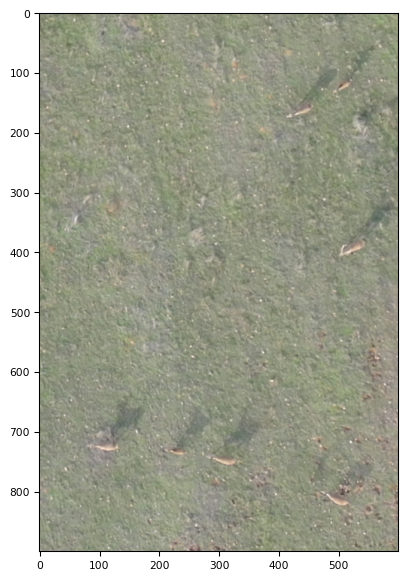

In [159]:
tiff.imshow(image_optical)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb5534c18>)

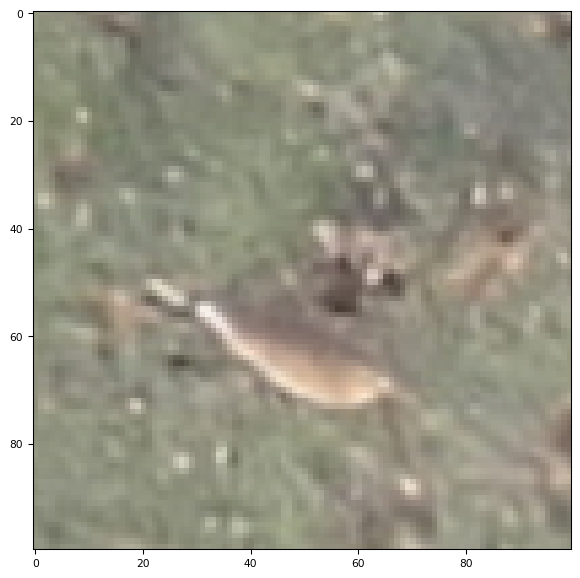

In [160]:
tiff.imshow(image_optical[750:850, 450:550])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb550beb8>)

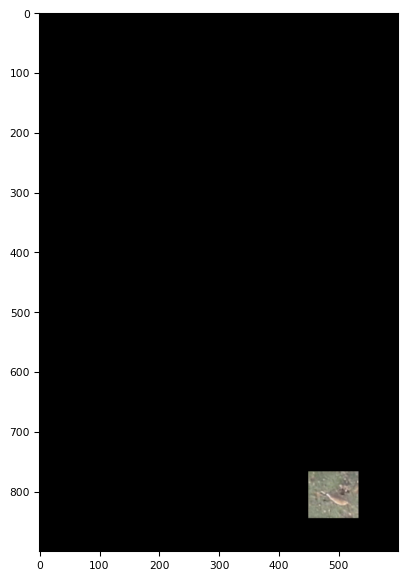

In [161]:
tiff.imshow(image_optical_masked_ROI_0)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb547a518>)

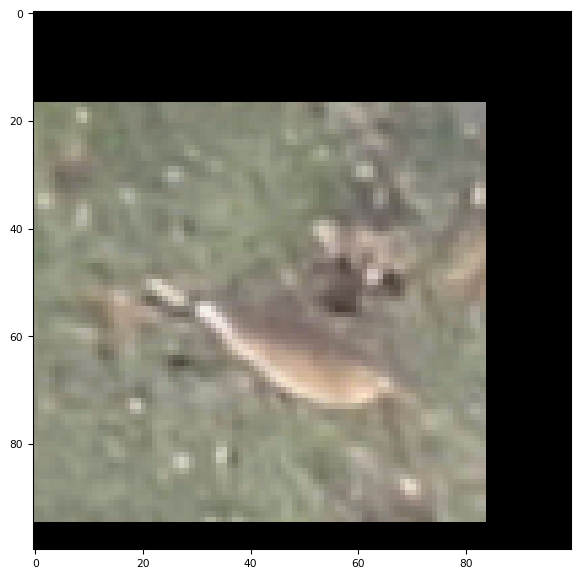

In [162]:
tiff.imshow(image_optical_masked_ROI_0[750:850, 450:550])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb54518d0>)

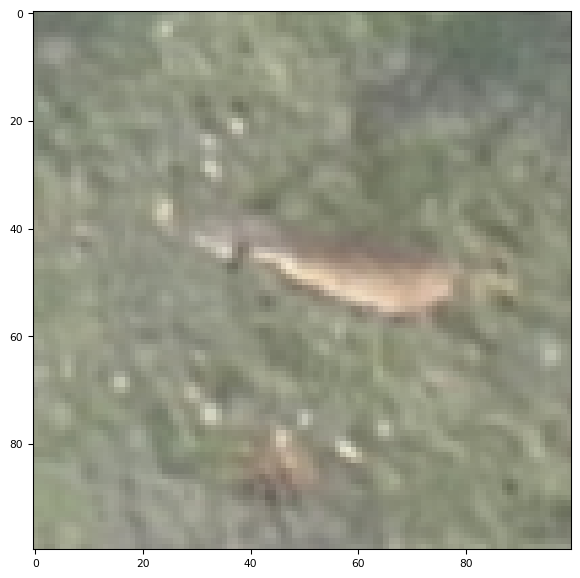

In [163]:
tiff.imshow(image_optical[700:800, 250:350])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb53a8b70>)

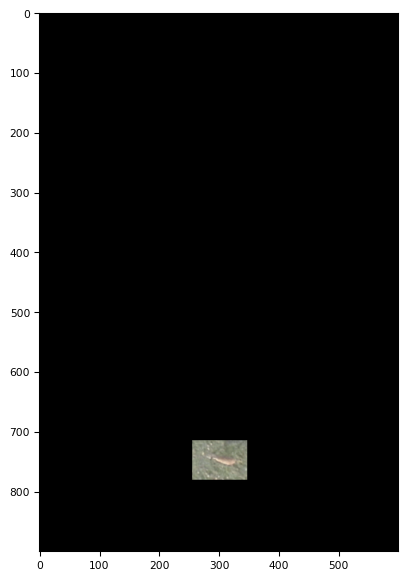

In [164]:
tiff.imshow(image_optical_masked_ROI_1)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7faeb5395208>)

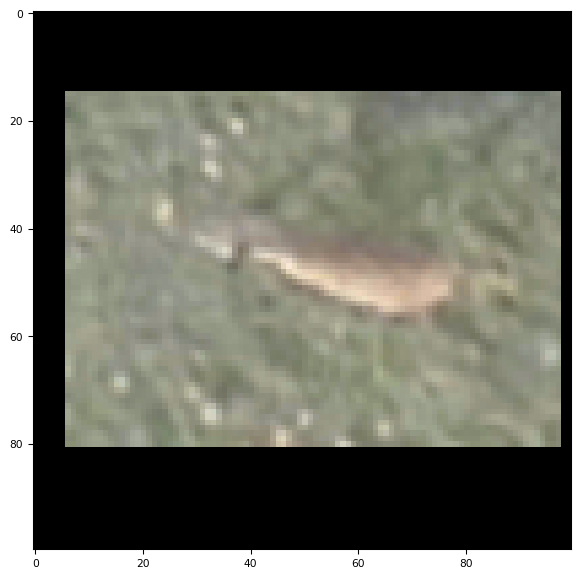

In [165]:
tiff.imshow(image_optical_masked_ROI_1[700:800, 250:350])